# TensorFlow・Kerasのトレーニング♨

## CNN - ちょっと高度なCNN 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [共通関数](#共通関数)
  - [CIFAR-10データ](#CIFAR-10データ)
- [高度なCNN](#高度なCNN)
  - [AlexNet](#AlexNet)
  - [VGG16](#VGG16)
  - [GoogLeNet](#GoogLeNet)
  - [ResNet](#ResNet)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python - DL  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python%20-%20DL

## [環境準備](TensorFlowAndKeras0.ipynb)

### インポート

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
print(tf.__version__)

import keras
print(keras.__version__)
# モデル定義
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, Input, Activation, Flatten, Dropout, LSTM
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import SGD, Adam
# その他
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2024-11-13 18:35:50.614983: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 18:35:50.627546: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 18:35:50.657461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731490550.691486    6184 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731490550.699641    6184 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 18:35:50.725071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2.18.0
3.6.0


### 共通関数

#### 画像確認

##### 画像とラベルの確認

In [2]:
def show_image_info(x, y, label, index):
    print("label: ", label[y[index]])
    print("Image: ")
    plt.imshow(x[index].astype(np.uint8))
    plt.show()

##### ランダムな画像一覧

In [3]:
def show_image_list(x, y, numOfCls=10, numOfImgInCls=10):
    pos = 1
    plt.figure(figsize=(numOfCls, numOfImgInCls))

    # クラス毎に以下の処理を繰り返す。
    for targetClass in range(numOfCls):
        targetIdx = []
        
        # 当該クラスの画像のインデックスリストを取得
        for i in range(len(y)):
            if y[i] == targetClass:
                targetIdx.append(i)
        
        # 当該クラスのインデックスリストからランダムに選んだ最初のn個の画像を描画
        np.random.shuffle(targetIdx)
        for idx in targetIdx[:numOfImgInCls]:
            plt.subplot(numOfCls, numOfImgInCls, pos)
            plt.imshow(x[idx])
            plt.axis('off')
            pos += 1

plt.show()

##### 誤った推論の画像を表示する関数

In [4]:
def show_incorrect_image_list(x, y, y_pred, label, numOfImg=10):
    index = (y != y_pred)
    for i, val in enumerate(index):
        if val == True:
            print('predict: ', label[y_pred[i]])
            print('answer : ', label[y[i]])
            show_image_info(x, y, label, i)
            numOfImg -= 1
            if numOfImg <= 0:
                break

#### [分類問題関連](ScikitLearnTraining5.ipynb)

##### 分類問題のメトリック表示関数

In [5]:
def print_metrics(label, pred):
    print('accuracy: %.3f' % metrics.accuracy_score(label, pred)) # 正答率
    
    print('\nmicro') # ミクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='micro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='micro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='micro')) # f値
    
    print('\nmacro') # マクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='macro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='macro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='macro')) # f値

##### 混同行列のグラフ化関数

In [6]:
def plot_cm(confmat, label):
    numOfCls = len(label)
    fig, ax = plt.subplots(figsize=(numOfCls, numOfCls))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
            
    # 軸目盛を打つ場所を決める
    ax.set_xticks(np.arange(len(label)))
    ax.set_yticks(np.arange(len(label)))
    # 軸目盛を設定
    ax.set_xticklabels(label)
    ax.set_yticklabels(label)
    #plt.xticks(np.array(label)) # x軸の目盛りを指定
    #plt.yticks(np.array(label)) # y軸の目盛りを指定
    
    plt.xlabel('y_pred label')
    plt.ylabel('y label')
    plt.show()

#### 学習履歴表示関数

##### 損失

In [7]:
def plot_history_loss(hist):
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

##### 正解率

In [8]:
def plot_history_acc(hist):
    plt.plot(hist.history['accuracy'],label="accuracy for training")
    plt.plot(hist.history['val_accuracy'],label="accuracy for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

### CIFAR-10データ

In [9]:
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10
(x_train_org, y_train_org), (x_test_org, y_test_org) = cifar10.load_data()
print(x_train_org.shape, x_test_org.shape)
print(y_train_org.shape, y_test_org.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [10]:
x_org = np.vstack([x_train_org, x_test_org])
y_org = np.concatenate([y_train_org, y_test_org])
print(x_org.shape, y_org.shape)

(60000, 32, 32, 3) (60000, 1)


In [11]:
x_std = x_org.astype('f')

In [12]:
x_std /= 255

In [13]:
# エンコーディング
yy = to_categorical(y_org.flatten(), num_classes=10).astype('i') 
# デコーディング
print((yy.argmax(axis=1) == y_org.flatten()).all())

True


In [14]:
x_train = x_std[:50000]
x_test = x_std[50000:]
y_train = yy[:50000]
y_test = yy[50000:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(x_train[0].shape) # input_shape

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)
(32, 32, 3)


## 高度なCNN

### AlexNet
AlexNet の CIFAR10 の accuracy は 0.60 とそれほど良くない。
- https://yamakatsusan.web.fc2.com/CIFAR10_AlexNet_Keras.html
- https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88CNN%EF%BC%89#w1e5ff6b

#### モデリング

##### 関数
厳密には以下が異なる。
- 分割・並列化はしていない。
- LRNではなくBNを使用。

In [15]:
def AlexNet(input_shape, num_classes=10):
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11),
                     strides=(4, 4),
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(3, 3),
                           strides=(2, 2),
                           padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size=(5, 5),
                     strides=(1, 1),
                     padding='same',
                     activation='relu'))
    
    model.add(MaxPool2D(pool_size=(3, 3),
                           strides=(2, 2),
                           padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(Conv2D(384, kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same',
                     activation='relu'))
    
    model.add(Conv2D(384, kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same',
                     activation='relu'))
    
    model.add(Conv2D(256, kernel_size=(3, 3),
                     strides=(1, 1),
                     padding='same',
                     activation='relu'))
    
    model.add(MaxPool2D(pool_size=(3, 3),
                           strides=(2, 2),
                           padding='same'))
    
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # コンパイル
    model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

##### コンパイル

In [16]:
model = AlexNet(x_train[0].shape, 10)
model.summary()

2024-11-13 18:35:56.839977: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 96)       │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       526,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,492,810 (32.40 MB)

 Trainable params: 8,491,594 (32.39 MB)

 Non-trainable params: 1,216 (4.75 KB)

#### 実行

##### 学習

```python
batch_size = 500
n_epoch = 30
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=batch_size,
                 epochs=n_epoch,
                 verbose=1)
```

###### 保存
結構時間がかかるのでモデルを保存しておく。

In [17]:
#model.save('../work/AlexNet.h5')

###### 復元

In [18]:
model = load_model('../work/AlexNet.h5')

##### 推論

###### 個別

label:  車
Image: 


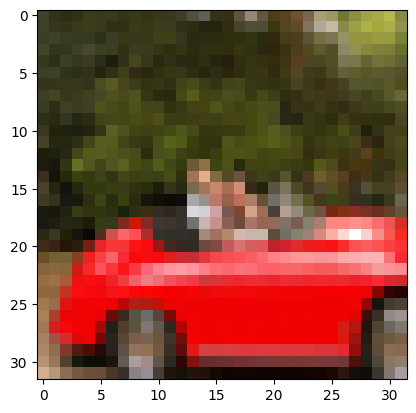

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
predict:  1
answer :  [1]
正解


In [19]:
index = 99
show_image_info(x_org, y_org.flatten(), ['飛','車','鳥','猫','鹿','犬','蛙','馬','船','貨'], index)

predict = model.predict(x_std[index].reshape(1, 32, 32, 3)).argmax()
answer  = y_org[index]

print('predict: ', predict)
print('answer : ', answer)

if predict == answer:
    print('正解')
else:
    print('不正解')

###### 一括

In [20]:
yy_pred = model.predict(x_std)

   1/1875 ━━━━━━━━━━━━━━━━━━━━ 5:23 173ms/step

2024-11-13 18:35:58.610067: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step


#### 評価
訓練データ92%、テストデータ62%、混ぜて87%と過学習している。

In [21]:
y_pred = np.array(yy_pred.argmax(axis=-1), dtype=np.uint8)
ret = (y_org.flatten() == y_pred)
print(str((len(np.where(ret==True)[0]) / ret.size) * 100) +'%')

87.14333333333333%


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
以下のコードが動かなくなっていたのでマークダウン・アウト

```python
score = model.evaluate(x_std, yy)
print('loss:', score[0])
print('accuracy:', score[1])
```

```python
train_score = model.evaluate(x_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
```

```python
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])
```

### VGG16
VGG16 の CIFAR10 の accuracy は 0.84 までに改善し、  
ファインチューニングするパターンでは 0.75 程度にしかならないらしい。
- https://qiita.com/tsekine2/items/e95d1cf704247dd3df7b
- https://qiita.com/kotai2003/items/e85f17d7213cf84e3bcd
- https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88CNN%EF%BC%89#b9831538

#### モデリング

##### 関数
- 分割・並列化はしていない。
- Batch Normalizationを使用。

In [22]:
def VGG16(input_shape, num_classes=10):
    model = Sequential()
    
    model.add(Conv2D(
        filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
        input_shape=input_shape, name='block1_conv1'))
    model.add(BatchNormalization(name='bn1'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block1_conv2'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Activation('relu'))
    
    model.add(MaxPool2D(
        pool_size=(2,2), strides=(2,2), padding='same', name='block1_pool'))
    
    model.add(Conv2D(
        filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block2_conv1'))
    model.add(BatchNormalization(name='bn3'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block2_conv2'))
    model.add(BatchNormalization(name='bn4'))
    model.add(Activation('relu'))
    
    model.add(MaxPool2D(
        pool_size=(2,2), strides=(2,2), padding='same', name='block2_pool'))
    
    model.add(Conv2D(
        filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block3_conv1'))
    model.add(BatchNormalization(name='bn5'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block3_conv2'))
    model.add(BatchNormalization(name='bn6'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block3_conv3'))
    model.add(BatchNormalization(name='bn7'))
    model.add(Activation('relu'))
    
    model.add(MaxPool2D(
        pool_size=(2,2), strides=(2,2), padding='same', name='block3_pool'))
    
    model.add(Conv2D(
        filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block4_conv1'))
    model.add(BatchNormalization(name='bn8'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block4_conv2'))
    model.add(BatchNormalization(name='bn9'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block4_conv3'))
    model.add(BatchNormalization(name='bn10'))
    model.add(Activation('relu'))
    
    model.add(MaxPool2D(
        pool_size=(2,2), strides=(2,2), padding='same', name='block4_pool'))
    
    model.add(Conv2D(
        filters=512, kernel_size=(3,3), strides=(1,1), padding='same', 
        name='block5_conv1'))
    model.add(BatchNormalization(name='bn11'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block5_conv2'))
    model.add(BatchNormalization(name='bn12'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(
        filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
        name='block5_conv3'))
    model.add(BatchNormalization(name='bn13'))
    model.add(Activation('relu'))
    
    model.add(MaxPool2D(
        pool_size=(2,2), strides=(2,2), padding='same', name='block5_pool'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=4096, activation='relu', name='fc1'))
    model.add(Dense(units=4096, activation='relu', name='fc2'))
    model.add(Dense(units=num_classes, activation='softmax', name='predictions'))

    # コンパイル
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

##### コンパイル

In [23]:
model = VGG16(x_train[0].shape, 10)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,16

 Total params: 33,655,114 (128.38 MB)

 Trainable params: 33,646,666 (128.35 MB)

 Non-trainable params: 8,448 (33.00 KB)

#### 実行

##### 学習

```python
batch_size = 500
n_epoch = 30
hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=batch_size,
                 epochs=n_epoch,
                 verbose=1)
```

##### 保存
結構時間がかかるのでモデルを保存しておく。

In [24]:
#model.save('../work/VGG16.h5')

##### 復元

In [25]:
model = load_model('../work/VGG16.h5')

##### 推論

###### 個別

label:  車
Image: 


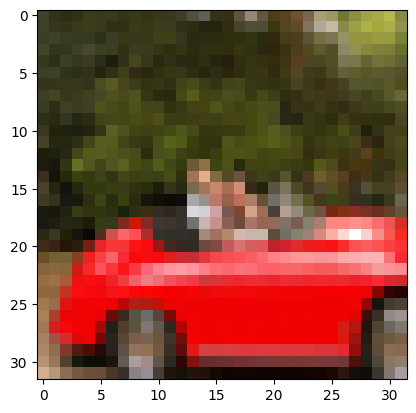

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
predict:  1
answer :  [1]
正解


In [26]:
index = 99
show_image_info(x_org, y_org.flatten(), ['飛','車','鳥','猫','鹿','犬','蛙','馬','船','貨'], index)

predict = model.predict(x_std[index].reshape(1, 32, 32, 3)).argmax()
answer  = y_org[index]

print('predict: ', predict)
print('answer : ', answer)

if predict == answer:
    print('正解')
else:
    print('不正解')

###### 一括

In [27]:
# The kernel appears to have died. It will restart automatically. と落ちるので100問に減らした。
yy_pred = model.predict(x_std[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


#### 評価
通常の学習で84%、事前学習＆ファインチューニングで75%と言う話だが、実際やったら訓練データ82%、テストデータ70%、混ぜて80%とパフォーマンスは出ていないが[AlexNet](#AlexNet)の過学習の問題は改善している模様。エポック数を30にしたが、20の方が性能が良いのかも？

In [28]:
y_pred = np.array(yy_pred.argmax(axis=-1), dtype=np.uint8)
ret = (y_org[:100].flatten() == y_pred[:100])
print(str((len(np.where(ret==True)[0]) / ret.size) * 100) +'%')

87.0%


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
以下のコードが動かなくなっていたのでマークダウン・アウト

```python
score = model.evaluate(x_std, yy)
print('loss:', score[0])
print('accuracy:', score[1])
```

```python
train_score = model.evaluate(x_train, y_train)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
```

```python
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])
```

## スペック不足で試せてないCNN

### GoogLeNet

In [ ]:
model = GoogLeNet(x_train[0].shape, 10)
model.summary()

##### 保存

In [ ]:
model.save('../work/GoogLeNet.h5')

##### 復元

In [ ]:
model = load_model('../work/GoogLeNet.h5')

### ResNet
ResNet-34 の CIFAR10 の accuracy は 0.95 までいけるらしい。
- https://qiita.com/TrashBoxx/items/2d441e46643f73c0ca19
- https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%EF%BC%88CNN%EF%BC%89#x56d1a9e

In [ ]:
model = ResNet(x_train[0].shape, 10)
model.summary()

##### 保存

In [ ]:
model.save('../work/ResNet.h5')

##### 復元

In [ ]:
model = load_model('../work/ResNet.h5')